# Preprocessing of Methylation Data
This notebook does some preprocessing for a script that takes annotation and downloaded methylation arrays and transforms it to one matrix $S \in \mathbb{R}^{p \times s}$ where $p$ is the number of genes and $s$ is the number of samples.

This matrix can then be used by yet another notebook to derive the final mean cancer type matrix.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn, h5py, os
from joblib import Parallel, delayed
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
%matplotlib inline

In [30]:
LOAD_ANNOTATION_WITH_PROM = True
USE_BASIC_ANNOTATION = True
m_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/download/ff41e5fe-2564-4f23-942b-60fbdd33b596/jhu-usc.edu_BRCA.HumanMethylation27.2.lvl-3.TCGA-BH-A0HW-01A-11D-A032-05.gdc_hg38.txt'
m_file2 = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/download/99b667be-e75c-458b-ba62-9931523b9504/jhu-usc.edu_UCEC.HumanMethylation450.23.lvl-3.TCGA-2E-A9G8-01A-11D-A409-05.gdc_hg38.txt'

## Load Methylation Array Data & Container
The methylation data gives us beta values per cpg sites. Each row corresponds to one cpg site. On the other hand, the annotation file gives us a list of genes and their genomic coordinates. It's wise to remove all the genes that we are not really interested in prior to calculating the mean beta values per gene because we then have to do less work.

In [3]:
m_df_1 = pd.read_csv(m_file, sep='\t')
m_df_1.dropna(axis=0, inplace=True)
m_df_2 = pd.read_csv(m_file2, sep='\t')
m_df_2.dropna(axis=0, inplace=True)

In [6]:
m_df_1.head()

,Composite Element REF,Beta_value,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type
0,cg00000292,0.884191,chr16,28878779,28878780,ATP2A1;ATP2A1;ATP2A1;ATP2A1;ATP2A1,protein_coding;protein_coding;protein_coding;p...,ENST00000357084.6;ENST00000395503.7;ENST000005...,373;290;-1275;-465;-83,CGI:chr16:28879633-28880547,N_Shore
1,cg00002426,0.027786,chr3,57757816,57757817,SLMAP;SLMAP;SLMAP;SLMAP;SLMAP;SLMAP,protein_coding;protein_coding;protein_coding;p...,ENST00000295951.6;ENST00000295952.6;ENST000003...,1585;368;261;257;257;514,CGI:chr3:57756198-57757263,S_Shore
2,cg00003994,0.098756,chr7,15686237,15686238,MEOX2,protein_coding,ENST00000262041.5,576,CGI:chr7:16399497-16399700,.
3,cg00005847,0.923172,chr2,176164345,176164346,AC009336.19;HOXD3;HOXD3;HOXD3;RP11-387A1.5,protein_coding;protein_coding;protein_coding;p...,ENST00000468418.4;ENST00000249440.4;ENST000004...,13259;267;3453;27387;1372,CGI:chr2:176164685-176165509,N_Shore
5,cg00007981,0.047147,chr11,94129428,94129429,PANX1;PANX1,protein_coding;protein_coding,ENST00000227638.6;ENST00000436171.2,499;498,CGI:chr11:94128394-94129607,Island


In [31]:
if LOAD_ANNOTATION_WITH_PROM:
    if USE_BASIC_ANNOTATION:
        anno_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/annotation_with_promoters_1000bp_basic.tsv'
    else:
        anno_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/annotation_with_promoters_1000bp.tsv'
    a_df = pd.read_csv(anno_file, sep='\t')
else:
    if USE_BASIC_ANNOTATION:
        anno_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/gencode.v28.basic.annotation.gff3'
    else:
        anno_file = '/project/gcn/diseasegcn/data/pancancer/TCGA/methylation/gencode.v28.annotation.gff3'
    a_df = pd.read_csv(anno_file, sep='\t', skiprows=7, header=None, names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attr'])
    a_df.dropna(axis=0, inplace=True)
    a_df = a_df[a_df.type == 'gene']
    annotated_gene_ids = [i[0].strip().split('=')[1].strip().split('.')[0].strip() for i in a_df.attr.str.split(';')]
    annotated_gene_names = [i[3].strip().split('=')[1].strip() for i in a_df.attr.str.split(';')]
    a_df['ID'] = annotated_gene_ids
    a_df['Symbol'] = annotated_gene_names
    a_df.drop_duplicates(subset='Symbol', inplace=True) # remove duplicate genes (not interested in transcript level)
a_df.head()

,Unnamed: 0,chr,source,type,start,end,score,strand,phase,attr,ID,Symbol,promoter_start,promoter_end
0,661,chr1,HAVANA,gene,944204.000,959309.000,.,-,.,ID=ENSG00000188976.10;gene_id=ENSG00000188976....,ENSG00000188976,NOC2L,958809.000,959809.000
1,705,chr1,HAVANA,gene,960587.000,965715.000,.,+,.,ID=ENSG00000187961.13;gene_id=ENSG00000187961....,ENSG00000187961,KLHL17,960087.000,961087.000
2,895,chr1,HAVANA,gene,998962.000,1000172.000,.,-,.,ID=ENSG00000188290.10;gene_id=ENSG00000188290....,ENSG00000188290,HES4,999672.000,1000672.000
3,931,chr1,HAVANA,gene,1001138.000,1014541.000,.,+,.,ID=ENSG00000187608.8;gene_id=ENSG00000187608.8...,ENSG00000187608,ISG15,1000638.000,1001638.000
4,959,chr1,HAVANA,gene,1020123.000,1056118.000,.,+,.,ID=ENSG00000188157.14;gene_id=ENSG00000188157....,ENSG00000188157,AGRN,1019623.000,1020623.000


In [90]:
cpg_sites.Start.min(), cpg_sites.Start.max()
np.arange(cpg_sites.Start.min(), cpg_sites.Start.max(), 100).shape, prom_signal[::100].shape

((986,), (4004,))

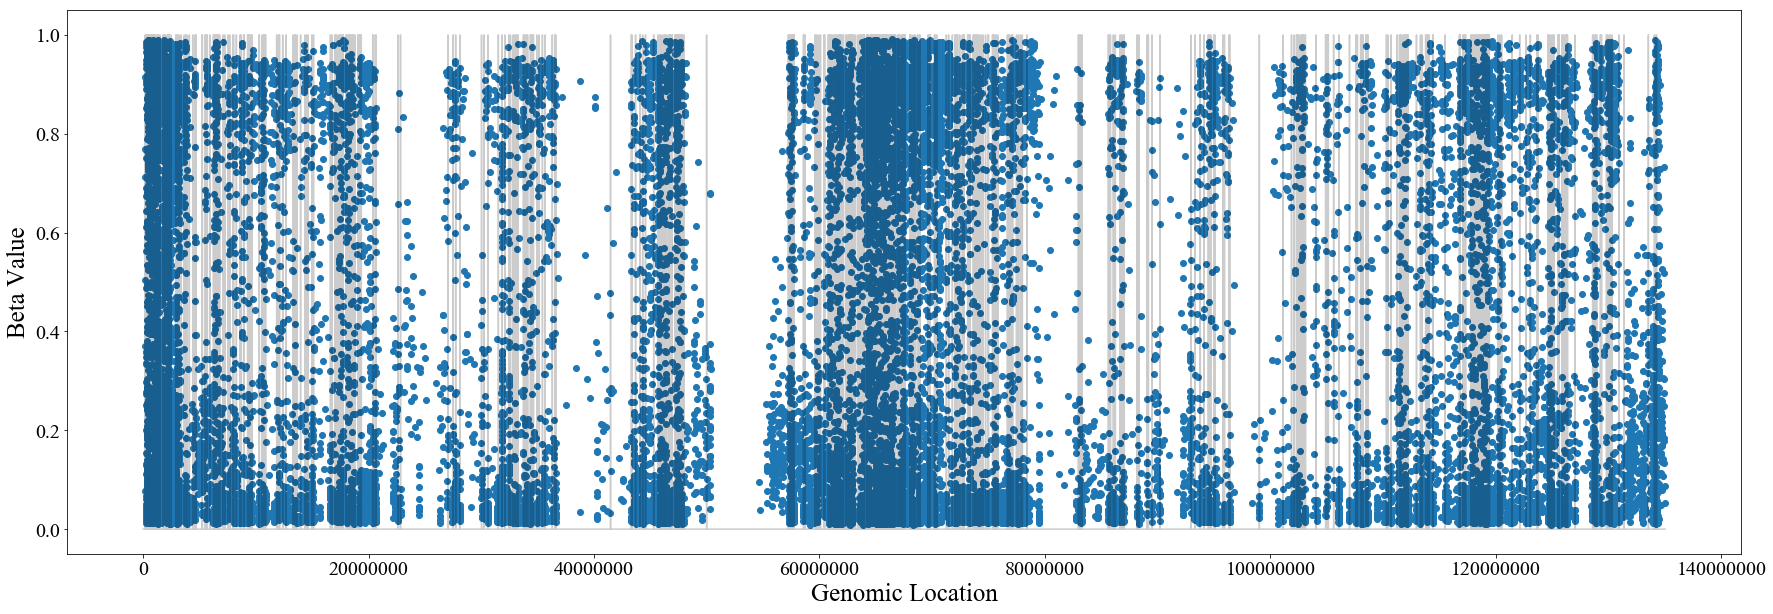

In [91]:
fig = plt.figure(figsize=(30, 10))
cpg_sites = m_df_2[m_df_2.Chromosome == 'chr11']
prom_signal = np.zeros(cpg_sites.Start.max())
proms = a_df[a_df.chr == 'chr11']
for _, row in proms.iterrows():
    prom_signal[int(row.promoter_start):int(row.promoter_end)] = 1
_ = plt.scatter(cpg_sites.Start, cpg_sites.Beta_value)
plt.plot(np.arange(0, cpg_sites.Start.max(), 1000), prom_signal[::1000], c='black', alpha=0.2)
plt.xlabel('Genomic Location', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('Beta Value', fontsize=25)

In [311]:
def get_float(string):
    try:
        return float(string)
    except:
        return np.inf

def get_closest_gene(row):
    # extract rows
    genes = np.array(row.Gene_Symbol.split(';'))
    protein_coding_genes = np.array([i == 'protein_coding' for i in row.Gene_Type.split(';')])
    dists = np.array([get_float(i) for i in row.Position_to_TSS.split(';')])
    #dists[dists < 0] = np.inf # we don't want negative values

    # remove non-protein-coding genes
    dists = dists[protein_coding_genes]
    genes = genes[protein_coding_genes]

    # return closest gene and distance
    if dists.shape[0] > 0:
        idx = np.argmin(np.abs(dists))
        return genes[idx], dists[idx]
    else:
        return None, None

x = m_df_2.apply(get_closest_gene, axis=1)
m_df_2['closest_gene'] = [i[0] for i in x]
m_df_2['dist_closest_gene'] = [i[1] for i in x]

0.0


ValueError: range parameter must be finite.

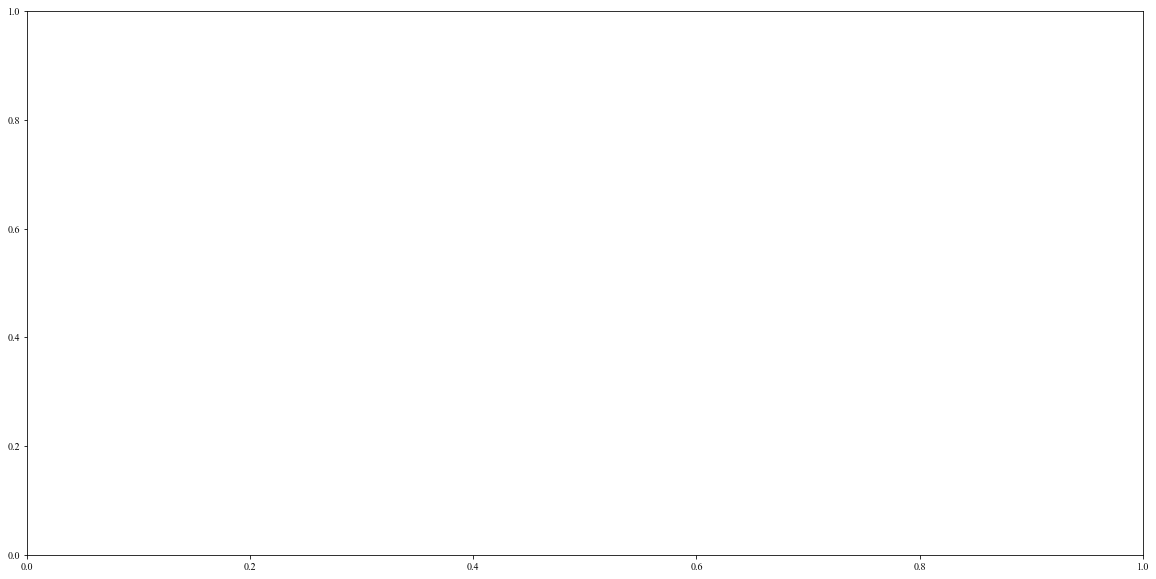

In [260]:
bins = np.linspace(-1000, 10000, 100)
print (m_df_2.dist_closest_gene.min())
m_df_2.dist_closest_gene.dropna().plot(kind='hist', bins=bins, figsize=(20, 10))

In [312]:
only_valid = m_df_2[m_df_2.dist_closest_gene.abs() < 1000]
prom_scores = only_valid.groupby('closest_gene').Beta_value.mean()
prom_support = only_valid.groupby('closest_gene').Beta_value.count()
res = pd.DataFrame(pd.concat((prom_scores, prom_support), axis=1))
res.columns = ['Beta_value', 'Support']

In [339]:
t = only_valid[only_valid.closest_gene == 'RUNX1']
t

,Composite Element REF,Beta_value,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type,closest_gene,dist_closest_gene
20933,cg00994804,0.150,chr21,34887086,34887087,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX...,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,162259;1605;1605;2705;98;162213;162213;1117582...,CGI:chr21:34886655-34887175,Island,RUNX1,98.000
27866,cg01337293,0.019,chr21,34889819,34889820,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,159526;-1128;-1128;-28;159480;159480;1114849;1...,CGI:chr21:34888153-34891390,Island,RUNX1,-28.000
31478,cg01519261,0.814,chr21,35049170,35049171,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000416754.1;ENST000004...,175;101;129;129;955498;119,CGI:chr21:35026663-35026962,.,RUNX1,101.000
35395,cg01725383,0.117,chr21,34887500,34887501,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX...,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,161845;1191;1191;2291;-316;161799;161799;11171...,CGI:chr21:34886655-34887175,S_Shore,RUNX1,-316.000
53741,cg02635869,0.078,chr21,34889803,34889804,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,159542;-1112;-1112;-12;159496;159496;1114865;1...,CGI:chr21:34888153-34891390,Island,RUNX1,-12.000
58319,cg02869559,0.204,chr21,34886770,34886771,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,162575;1921;1921;3021;414;162529;162529;162519,CGI:chr21:34886655-34887175,Island,RUNX1,414.000
61450,cg03017480,0.035,chr21,34888732,34888733,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,160613;-41;-41;1059;160567;160567;1115936;160557,CGI:chr21:34888153-34891390,Island,RUNX1,-41.000
63837,cg03142697,0.067,chr21,34886200,34886201,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,163145;2491;2491;3591;984;163099;163099;163089,CGI:chr21:34886655-34887175,N_Shore,RUNX1,984.000
87510,cg04357830,0.036,chr21,34889396,34889397,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000344691.7;ENST000003...,159949;-705;-705;395;159903;159903;1115272;159893,CGI:chr21:34888153-34891390,Island,RUNX1,395.000
98115,cg04915566,0.912,chr21,35049175,35049176,RUNX1;RUNX1;RUNX1;RUNX1;RUNX1;RUNX1,protein_coding;protein_coding;protein_coding;p...,ENST00000300305.6;ENST00000416754.1;ENST000004...,170;96;124;124;955493;114,CGI:chr21:35026663-35026962,.,RUNX1,96.000


In [316]:
def get_mean_betaval_for_sample(annotation_genes, methylation_levels):
    """Extract mean methylation levels in promoters/gene bodies for each annotated gene.
    
    This function looks for all the methylation sites that fall
    inside all the promoters and gene bodies in the annotation genes df.
    The annotation_genes df is expected to contain the columns
    'promoter_start' and 'promoter_end'.
    
    Parameters:
    ----------
    annotation_genes:           A dataframe containing a gene per row.
                                It needs to have columns for promoter_start
                                and promoter_end.
    methylation_levels:         A dataframe that contains cpg sites per row.
                                The sites are expected to be one bp long and
                                should have the columns: 'Start', 'End' and 
                                Beta_value'.
    Returns:
    Two lists with the mean beta values for each promoter and the number of cpg sites
    that support the promoter. The first list contains the mean beta values and
    the second list contains the support.
    """
    beta_vals_prom = []
    beta_vals_gene = []
    n_supports_prom = []
    n_supports_gene = []
    count = 0
    for _, row in annotation_genes.iterrows():
        # restrict possible sites to same chr
        cpgs_on_chr = methylation_levels[methylation_levels.Chromosome == row.chr]
        # promoter
        m_sites_in_promoter = cpgs_on_chr[cpgs_on_chr.Start.between(row.promoter_start, row.promoter_end)]
        beta_vals_prom.append(m_sites_in_promoter.Beta_value.mean())
        n_supports_prom.append(m_sites_in_promoter.shape[0])
        # gene body. Don't start with the start and end coordinates but rather with the end of the promoter
        if row.strand == '+':
            m_sites_gene = cpgs_on_chr[cpgs_on_chr.Start.between(row.promoter_end, row.end)]
        else:
            m_sites_gene = cpgs_on_chr[cpgs_on_chr.Start.between(row.start, row.promoter_start)]
        beta_vals_gene.append(m_sites_gene.Beta_value.mean())
        n_supports_gene.append(m_sites_gene.shape[0])
        count += 1
    return beta_vals_prom, beta_vals_gene, n_supports_prom, n_supports_gene


def get_float(string):
    """ Convert a string into a float.

    This function converts a string to float if the string represents a floating
    point number (or integer). If that is not the case, it returns NaN.

    Parameters:
    ----------
    string:                     The string that is to be converted to float.

    Returns:
    A floating point number. Either with the value from `string` or numpy.nan
    """
    try:
        return float(string)
    except:
        return np.inf

def get_closest_gene(row):
    """ Get the closest gene from a row of TCGA level 3 methylation data.

    Extracts the gene name of the closest transcript promoter from
    a row of TCGA DNA methylation data (level 3). Each of the lines
    contain the coordinates of the CpG site together with information
    on the closest gene around it. There are three relevant fields (columns)
    for that: Gene_Symbol, Transcript_ID and Position_to_TSS.
    
    Parameters:
    ----------
    row:                        A row from a TCGA DNA methylation Dataframe.
                                Should contain the columns `Position_to_TSS`
                                and `Gene_Symbol`.
    """
    # extract rows
    genes = np.array(row.Gene_Symbol.split(';'))
    protein_coding_genes = np.array([i == 'protein_coding' for i in row.Gene_Type.split(';')])
    dists = np.array([get_float(i) for i in row.Position_to_TSS.split(';')])

    # remove non-protein-coding genes
    dists = dists[protein_coding_genes]
    genes = genes[protein_coding_genes]

    # return closest gene and distance
    if dists.shape[0] > 0:
        idx = np.argmin(np.abs(dists))
        return genes[idx], dists[idx]
    else:
        return None, None

def get_promoter_betaval_tcgaannotation(methylation_levels):
    # write to DF which is the closest gene
    x = methylation_levels.apply(get_closest_gene, axis=1)
    methylation_levels['closest_gene'] = [i[0] for i in x]
    methylation_levels['dist_closest_gene'] = [i[1] for i in x]

    # filter
    close_cpgs = methylation_levels[methylation_levels.dist_closest_gene.abs() < 1000]

    # group and return
    cpgs_for_genes = close_cpgs.groupby('closest_gene')
    beta_values_prom = cpgs_for_genes.Beta_value.mean()
    n_supports_prom = cpgs_for_genes.Beta_value.count()

    return beta_values_prom, n_supports_prom

def load_methylation_file(path):
    m_df = pd.read_csv(path, sep='\t')
    m_df.dropna(axis=0, inplace=True)
    return m_df

def get_meth_df_for_sample(annotation_df, path_name, clean=False, tcga_annot=False):
    """Calculates the mean methylation DF for one sample.
    
    This function computes the mean methylation level at
    the promoter and gene body for all genes in the annotation
    dataframe using the methylation data specified in the path
    name. Note that this must be in the TCGA methylation format.
    The annotation dataframe is expected to contain the promoter
    region in the columns 'promoter_start' and 'promoter_end'.
    If the directory of the file given by 'path_name' contains
    already a file 'avg_methylation.tsv', this will be loaded
    and returned simply instead of re-extracting the methylation
    values. If clean is set to True, the extraction takes place
    in any case.
    """
    sub_dirname = os.path.dirname(path_name)
    fname = os.path.basename(path_name)
    if tcga_annot:
        avg_meth_result_path = os.path.join(sub_dirname,
                'avg_methylation_tcgaannot.tsv'
                )
    else:
        avg_meth_result_path = os.path.join(sub_dirname,
                        'avg_methylation.tsv'
                        )
    # get the cancer type first
    cancer_type = fname.split('.')[1].split('_')[1].strip().lower()
    sample_id = fname.split('.')[-3].strip()
    if not os.path.isfile(avg_meth_result_path) or clean:
        # get mean methylation levels around promoters
        meth_df = load_methylation_file(path_name)
        if tcga_annot:
            beta_prom, sup_prom = get_promoter_betaval_tcgaannotation(meth_df)
            res = pd.DataFrame([beta_prom, sup_prom]).T
            colnames = ['mean_beta_value_promoter', 'support_promoter']
            cols = ['{}|{}|{}'.format(sample_id, cancer_type, i) for i in colnames]
            res.columns = cols
            
        else:
            beta_p, beta_g, sup_p, sup_g = get_mean_betaval_for_sample(annotation_df,
                                                                       meth_df)
            # construct dataframe from results
            res = pd.DataFrame([beta_p, sup_p, beta_g, sup_g]).T
            colnames = ['mean_beta_value_promoter', 'support_promoter',
                        'mean_beta_value_gene', 'support_gene']
            cols = ['{}|{}|{}'.format(sample_id, cancer_type, i) for i in colnames]
            res.columns = cols
        #res.set_index(annotation_df.Symbol, inplace=True) # assumes same order
        # add dataframe to overall results and write to file

        # write the average beta values (at promoters) to file
        #res.to_csv(avg_meth_result_path, sep='\t')
    else:
        res = pd.read_csv(avg_meth_result_path, sep='\t')
        res.set_index('Symbol', inplace=True)
    return res, cancer_type

In [317]:
test, ctype = get_meth_df_for_sample(None, m_file2, clean=False, tcga_annot=True)

In [334]:
test[test.index == 'ABL1']

,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_promoter
closest_gene,,
ABL1,0.136,13.000


## Get Promoter Start and End

In [7]:
def promoter_window_wrapper(row):
    start, end = get_promotor_window(row['start'], row['end'], row['strand'])
    return start, end


def get_promotor_window(start, end, strand, meth_data=None):
    if strand == '+':
        tss = start
    else:
        tss = end
    if not meth_data is None: # fancy method to get promoter
        scan_region = (np.max(tss-1000, 0), tss + 1000)
        return calculate_promoter_window(scan_region[0], scan_region[1], meth_data)
    else:
        return np.max(tss-500, 0), tss + 500


def calculate_promoter_window(scan_start, scan_end, meth_data, shift=50, size=200):
    best_mean_meth = None
    best_window = (None, None)
    for i in range(int(scan_start), int(scan_end-size+1), shift):
        # get mean meth for window
        m_sites_window = meth_data[meth_data.Start.between(i, i+size)]
        m_mean_window = m_sites_window.Beta_value_mean.mean()
        
        # decide on best window
        if best_mean_meth is None: # first window
            best_mean_meth = m_mean_window
            best_window = i, i+size
        else: # any of the later windows
            if abs(best_mean_meth-m_mean_window) > 0.25: # large change in mean detected
                break
            else: # make the current window the best one
                best_mean_meth = m_mean_window
                best_window = i, i+size
    return best_window
promoter_vec = np.vectorize(get_promotor_window)

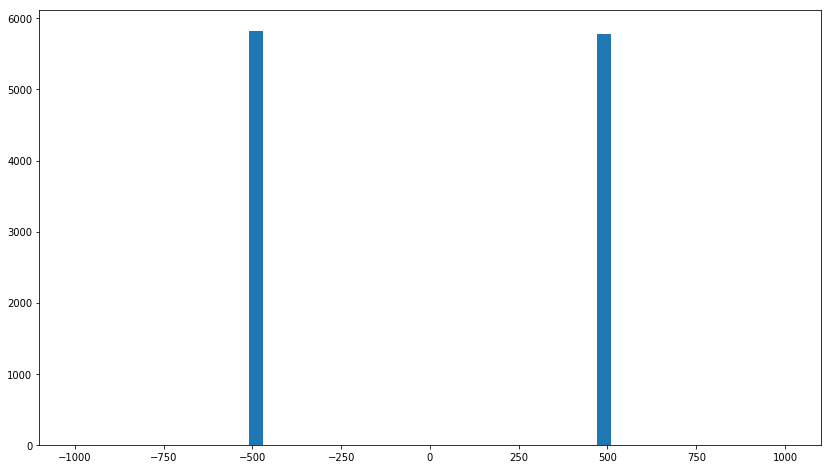

In [8]:
# get promoter start and end
x = a_df.apply(promoter_window_wrapper, axis=1)

# set it in the annotation dataframe and save that back to file
p_starts = np.array([i[0] for i in x])
p_ends = np.array([i[1] for i in x])
a_df['promoter_start'] = p_starts
a_df['promoter_end'] = p_ends
if USE_BASIC_ANNOTATION:
    a_df.to_csv('../../data/pancancer/TCGA/methylation/annotation_with_promoters_1000bp_basic.tsv', sep='\t')
else:
    a_df.to_csv('../../data/pancancer/TCGA/methylation/annotation_with_promoters_1000bp.tsv', sep='\t')

# do a plot of the distribution
a_df['TSS'] = 0
a_df.loc[a_df.strand == '+', 'TSS'] = a_df[a_df.strand == '+'].promoter_start
a_df.loc[a_df.strand == '-', 'TSS'] = a_df[a_df.strand == '-'].promoter_end
d_to_prom = a_df.TSS - (p_ends+p_starts)/2
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(-1000, 1000, 50)
_ = plt.hist(d_to_prom, bins=bins)

## Get Experimental Strategy & Number of Samples

In [17]:
def get_filenames(meth_raw_dir):
    all_filenames = []
    for dname in os.listdir(meth_raw_dir):
        sub_dirname = os.path.join(meth_raw_dir, dname)
        if os.path.isdir(sub_dirname):
            for fname in os.listdir(sub_dirname):
                if fname.endswith('gdc_hg38.txt'):
                    all_filenames.append(os.path.join(sub_dirname, fname))
    return all_filenames

all_files = get_filenames('../../data/pancancer/TCGA/methylation/download/')

ctype_prots = {}
for f in all_files:
    fname = os.path.basename(f)
    protocol = fname.split('.')[2]
    cancer_type = fname.split('.')[1].split('_')[1].strip().lower()
    if not cancer_type in ctype_prots:
        ctype_prots[cancer_type] = [protocol]
    else:
        ctype_prots[cancer_type] = ctype_prots[cancer_type] + [protocol]

In [18]:
for c in ctype_prots:
    no_27k = len([i for i in ctype_prots[c] if i.endswith('27')])
    prop = no_27k / len(ctype_prots[c])
    print ("{} -> Total #Samples: {}\t#27k Arrays: {}\tProportion: {}".format(c, len(ctype_prots[c]), no_27k, prop))

laml -> Total #Samples: 280	#27k Arrays: 140	Proportion: 0.5
ucec -> Total #Samples: 603	#27k Arrays: 118	Proportion: 0.1956882255389718
hnsc -> Total #Samples: 580	#27k Arrays: 0	Proportion: 0.0
luad -> Total #Samples: 657	#27k Arrays: 150	Proportion: 0.228310502283105
kirc -> Total #Samples: 899	#27k Arrays: 414	Proportion: 0.46051167964404893
ov -> Total #Samples: 623	#27k Arrays: 613	Proportion: 0.9839486356340289
gbm -> Total #Samples: 450	#27k Arrays: 295	Proportion: 0.6555555555555556
brca -> Total #Samples: 1234	#27k Arrays: 342	Proportion: 0.2771474878444084
lusc -> Total #Samples: 573	#27k Arrays: 161	Proportion: 0.28097731239092494
blca -> Total #Samples: 440	#27k Arrays: 0	Proportion: 0.0
coad -> Total #Samples: 556	#27k Arrays: 203	Proportion: 0.36510791366906475
read -> Total #Samples: 179	#27k Arrays: 73	Proportion: 0.40782122905027934
